# Building the 1D CNN

### Import the relevant packages

In [1]:
%matplotlib inline
import expressyeaself.construct_neural_net as construct
import expressyeaself.encode_sequences as encode
import expressyeaself.organize_data as organize 
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import subprocess
import sys
from tqdm import tqdm

import tensorflow as tf
tf.get_variable('test_bool', 1, tf.bool)
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import StratifiedKFold

ROOT_DIR = os.getcwd() + '/'
CHECKPOINTS_DIR = ROOT_DIR + 'expressyeaself/models/1dcnn/checkpoints/'

### Define the input data

In [2]:
sample_filename = '10000_from_20190608104912821947_sequences_inserted_into_Abf1TATA_scaffold_padded_at_back_with_exp_levels.txt.gz'
sample_path = ROOT_DIR + 'example/processed_data/' + sample_filename



### Encode sequences

In [3]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, method='One-Hot', scale_els=True, model_type='1DCNN')
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)


### Reshape expression levels

In [4]:
scaler = MinMaxScaler()
y_scaled = y_scaled.reshape((len(y_scaled), 1))
scaler.fit(y_scaled)
y_scaled = scaler.transform(y_scaled)

### Perform a train-test split

In [6]:
test_size = 0.2

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=test_size)

### Build the model architecture

In [9]:
scores = []
batch_size = 100

In [10]:
tb = TensorBoard(log_dir='./logs', histogram_freq=3, batch_size=batch_size, write_graph=True, write_grads=True, 
                 write_images=True)
checkpointer = ModelCheckpoint(monitor='val_acc', filepath=(CHECKPOINTS_DIR + '1dcnn_onehot.hdf5'), verbose=1, save_best_only=True)



W0608 11:44:11.092257 4705260992 callbacks.py:1466] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0608 11:44:11.093986 4705260992 callbacks.py:1469] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


In [33]:
filters = 32
kernel_size = 32
strides = 3
num_classes = 1
epochs = 5

model = Sequential()
model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(max_sequence_len, 5)))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(3, strides))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.8))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_47 (Conv1D)           (None, 261, 32)           5152      
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 230, 32)           32800     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 76, 32)            0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 45, 32)            32800     
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 14, 32)            32800     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)              

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 16s 2ms/sample - loss: 0.0475 - acc: 0.0153 - val_loss: 0.0435 - val_acc: 0.0205
Epoch 2/5
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0422 - acc: 0.0179 - val_loss: 0.0505 - val_acc: 0.0175
Epoch 3/5
8000/8000 [==============================] - 24s 3ms/sample - loss: 0.0407 - acc: 0.0179 - val_loss: 0.0377 - val_acc: 0.0220
Epoch 4/5
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0402 - acc: 0.0180 - val_loss: 0.0373 - val_acc: 0.0220
Epoch 5/5
8000/8000 [==============================] - 22s 3ms/sample - loss: 0.0376 - acc: 0.0195 - val_loss: 0.0357 - val_acc: 0.0220
acc: 2.20%


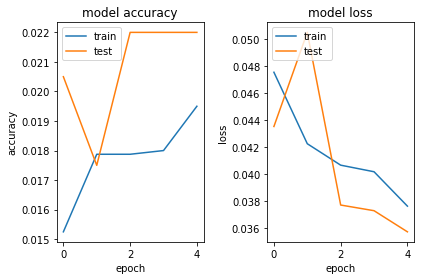

In [34]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(X_test, y_test))#, callbacks=[checkpointer])

# evaluate the model
score = max(history.history['val_acc'])
scores.append(score)
print("%s: %.2f%%" % (model.metrics_names[1], score*100))
plt = construct.plot_results(history.history)
plt.show()

In [ ]:
scores